# Prep_Results_Sim4


In [67]:
#imports
import os
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import math
import textwrap
import warnings
warnings.filterwarnings("ignore", message=".*observed=False is deprecated.*")
import re
from pathlib import Path

os.makedirs("Figures4", exist_ok=True)

## Laden & Aufbereiten

In [52]:
RESULTS_DIR = "Results4"                 # Basisordner
PREP_DIR = os.path.join(RESULTS_DIR, "Prepared4")
os.makedirs(PREP_DIR, exist_ok=True)
print("Nutze Ergebnisordner:", os.path.abspath(PREP_DIR))

# Schwelle wie im R-Code (numerische Toleranz)
EPS = 1e-8

def load_all_pickles(results_dir):
    """Lädt alle Pickle-Dateien 'Sim1.k_<k>.rho_<rho>.pkl' aus results_dir."""
    pattern = os.path.join(results_dir, "Sim1.k_*.rho_*.pkl")
    files = sorted(glob.glob(pattern))
    if not files:
        print("Keine Dateien gefunden unter", pattern)
    items = []
    for fn in files:
        try:
            with open(fn, 'rb') as f:
                data = pickle.load(f)
            # Extrahiere k und rho aus Dateinamen zur Sicherheit
            base = os.path.basename(fn)
            # Format: Sim1.k_<k>.rho_<rho>.pkl
            k_str = base.split('k_')[1].split('.rho_')[0]
            rho_str = base.split('rho_')[1].split('.pkl')[0]
            k = int(k_str)
            rho = float(rho_str)
            data['k'] = int(data.get('k', k))
            data['rho'] = float(data.get('rho', rho))
            data['__file__'] = fn
            items.append(data)
        except Exception as e:
            print(f"Fehler beim Laden von {fn}: {e}")
    return items

def as_df_long_diff(diff_mat, method_names, instance_offset, scenario_id, value_name, k, rho):
    """Formt eine (sim_nr x nr_methods)-Matrix in Long-Format; inkl. k & rho."""
    sim_nr, nr_methods = diff_mat.shape
    df = pd.DataFrame(diff_mat, columns=method_names)
    df['instance'] = np.arange(sim_nr) + instance_offset
    df['scenario'] = scenario_id
    long_df = df.melt(id_vars=['instance', 'scenario'], var_name='variable', value_name=value_name)
    long_df['k'] = k
    long_df['rho'] = rho
    return long_df

def make_long_sim4(all_data):
    rows_m, rows_m2, rows_rt = [], [], []
    for b in all_data:
        mBIC  = np.asarray(b['mBIC_results'],  dtype=float)
        mBIC2 = np.asarray(b['mBIC2_results'], dtype=float)
        rt    = np.asarray(b['runtime'],       dtype=float)
        methods = list(b['method_names'])
        scen = int(b['scenario'])

        # differences vs baseline (col 0 = stepwise_plain)
        res  = mBIC  - mBIC[:, [0]]
        res2 = mBIC2 - mBIC2[:, [0]]

        for j, m in enumerate(methods):
            vi = ~np.isnan(res[:, j])
            if vi.any():
                rows_m  += [{'scenario':scen,'sim':int(i),'method':m,'mBIC':  float(res[i,j])} for i in np.where(vi)[0]]
            v2 = ~np.isnan(res2[:, j])
            if v2.any():
                rows_m2 += [{'scenario':scen,'sim':int(i),'method':m,'mBIC2': float(res2[i,j])} for i in np.where(v2)[0]]
            vr = ~np.isnan(rt[:, j])
            if vr.any():
                rows_rt += [{'scenario':scen,'sim':int(i),'method':m,'Runtime':float(rt[i,j])}  for i in np.where(vr)[0]]

    df_m   = pd.DataFrame(rows_m)
    df_m2  = pd.DataFrame(rows_m2)
    df_rt  = pd.DataFrame(rows_rt)

    # keep method ordering if available
    for d in (df_m, df_m2, df_rt):
        if not d.empty:
            d['method'] = pd.Categorical(d['method'], categories=method_order, ordered=True)
    return df_m, df_m2, df_rt

df_m_long, df_m2_long, df_rt_long = make_long_sim4(all_data)
print("long shapes:", df_m_long.shape, df_m2_long.shape, df_rt_long.shape)

Nutze Ergebnisordner: /dss/dsshome1/0C/ra96quq2/MA/Results4/Prepared4
long shapes: (3200, 4) (3200, 4) (3200, 4)


In [53]:
# ============================ SIM 4: Laden & Aufbereiten ============================

RESULTS_DIR = "Results4"
EPS = 1e-8

def load_all_pickles_sim4(results_dir):
    """
    Lädt Dateien wie 'Scen{scenario}.k_{k}.pkl' aus results_dir
    und normalisiert die Keys auf die im Notebook verwendeten Namen.
    """
    import glob, os, pickle
    files = sorted(glob.glob(os.path.join(results_dir, "Scen*.k_*.pkl")))
    if not files:
        print("Keine Dateien gefunden unter", os.path.join(results_dir, "Scen*.k_*.pkl"))
    out = []
    for fn in files:
        try:
            with open(fn, "rb") as f:
                raw = pickle.load(f)
            # Normalisierung der Schlüsselnamen:
            block = {
                "mBIC_results":  raw["mBIC.results"],
                "mBIC2_results": raw["mBIC2.results"],
                "mBIC_FP":       raw["mBIC.FP"],
                "mBIC2_FP":      raw["mBIC2.FP"],
                "mBIC_TP":       raw["mBIC.TP"],
                "mBIC2_TP":      raw["mBIC2.TP"],
                "runtime":       raw["runtime"],
                "method_names":  list(raw["method_names"]),
                "k":             int(raw.get("k", 20)),
                "scenario":      int(raw.get("scenario", -1)),
                "__file__":      fn,
            }
            out.append(block)
        except Exception as e:
            print(f"Fehler beim Laden {fn}: {e}")
    return out

all_data = load_all_pickles_sim4(RESULTS_DIR)
if not all_data:
    raise RuntimeError("Keine Sim4-Dateien gefunden.")

# Methodenreihenfolge (erste Sichtung)
method_order = []
for blk in all_data:
    for m in blk['method_names']:
        if m not in method_order:
            method_order.append(m)

# ---------------- NaN-robuste Auswertung pro Block ----------------
df_rows = []
instance_offset = 0

for block in all_data:
    mBIC_results  = np.asarray(block['mBIC_results'],  dtype=float)
    mBIC2_results = np.asarray(block['mBIC2_results'], dtype=float)
    mBIC_FP       = np.asarray(block['mBIC_FP'],       dtype=float)
    mBIC2_FP      = np.asarray(block['mBIC2_FP'],      dtype=float)
    mBIC_TP       = np.asarray(block['mBIC_TP'],       dtype=float)
    mBIC2_TP      = np.asarray(block['mBIC2_TP'],      dtype=float)
    runtime       = np.asarray(block['runtime'],       dtype=float)
    method_names  = list(block['method_names'])
    k             = int(block['k'])
    scenario      = int(block['scenario'])

    sim_nr, nr_methods = mBIC_results.shape

    # Baseline = Methode 0 (stepwise_plain)
    stepwise  = mBIC_results[:, [0]]
    stepwise2 = mBIC2_results[:, [0]]

    res  = mBIC_results  - stepwise
    res2 = mBIC2_results - stepwise2

    # gültige Einträge
    valid_res  = ~np.isnan(res)
    valid_res2 = ~np.isnan(res2)

    Worse   = np.sum((res  >  EPS) & valid_res,  axis=0).astype(int)
    Better  = np.sum((res  < -EPS) & valid_res,  axis=0).astype(int)
    Worse2  = np.sum((res2 >  EPS) & valid_res2, axis=0).astype(int)
    Better2 = np.sum((res2 < -EPS) & valid_res2, axis=0).astype(int)

    FP    = np.nanmean(mBIC_FP,  axis=0)
    TP    = np.nanmean(mBIC_TP,  axis=0)
    Power = (TP / k) if k > 0 else np.zeros_like(TP)

    FP2    = np.nanmean(mBIC2_FP, axis=0)
    TP2    = np.nanmean(mBIC2_TP, axis=0)
    Power2 = (TP2 / k) if k > 0 else np.zeros_like(TP2)

    denom = mBIC2_FP + mBIC2_TP
    with np.errstate(divide='ignore', invalid='ignore'):
        fdr2_sim = np.where(denom > 0, mBIC2_FP / denom, 0.0)
    FDR2 = np.nanmean(fdr2_sim, axis=0)

    n_eff_mBIC  = np.sum(valid_res,  axis=0)
    n_eff_mBIC2 = np.sum(valid_res2, axis=0)

    mean_mBIC  = np.nanmean(res,  axis=0)
    sd_mBIC    = np.nanstd(res,   axis=0, ddof=1)
    sem_mBIC   = np.where(n_eff_mBIC  > 0, sd_mBIC  / np.sqrt(n_eff_mBIC),  np.nan)

    mean_mBIC2 = np.nanmean(res2, axis=0)
    sd_mBIC2   = np.nanstd(res2,  axis=0, ddof=1)
    sem_mBIC2  = np.where(n_eff_mBIC2 > 0, sd_mBIC2 / np.sqrt(n_eff_mBIC2), np.nan)

    Runtime = np.nanmean(runtime, axis=0)

    # Aggregatzeilen pro Methode
    for l, mname in enumerate(method_names):
        df_rows.append({
            'scenario': scenario,
            'method': mname,
            'Better': int(Better[l]), 'Worse': int(Worse[l]),
            'Better2': int(Better2[l]), 'Worse2': int(Worse2[l]),
            'FP': float(FP[l]), 'Power': float(Power[l]),
            'FDR2': float(FDR2[l]), 'Power2': float(Power2[l]),
            'mean_mBIC': float(mean_mBIC[l]), 'sem_mBIC': float(sem_mBIC[l]),
            'mean_mBIC2': float(mean_mBIC2[l]), 'sem_mBIC2': float(sem_mBIC2[l]),
            'Runtime': float(Runtime[l]),
            'n_block': int(sim_nr),
            'n_valid_mBIC': int(n_eff_mBIC[l]),
            'n_valid_mBIC2': int(n_eff_mBIC2[l]),
        })

df = pd.DataFrame(df_rows)
if df.empty:
    raise RuntimeError("Leeres df – keine Sim4-Daten nach Aggregation.")

# Ordnung/Typen
df['method'] = pd.Categorical(df['method'], categories=method_order, ordered=True)
df['scenario'] = df['scenario'].astype(int)

print("Sim4 geladen. df shape:", df.shape)
display(df.head())


Sim4 geladen. df shape: (32, 18)


,scenario,method,Better,Worse,Better2,Worse2,FP,Power,FDR2,Power2,mean_mBIC,sem_mBIC,mean_mBIC2,sem_mBIC2,Runtime,n_block,n_valid_mBIC,n_valid_mBIC2
0,1,stepwise_plain,0,0,0,0,0.10,0.2025,0.053925,0.2550,0.000000,0.000000,0.000000,0.000000,137.074836,100,100,100
1,1,GSDAR,2,66,0,80,0.11,0.1585,0.057968,0.1820,5.880296,0.885531,9.867511,1.174297,15.360369,100,100,100
2,1,L0opt_CD,2,15,2,23,0.10,0.2045,0.056017,0.2565,0.200627,0.076799,0.219965,0.070081,1.057632,100,100,100
3,1,L0opt_CDPSI,2,9,3,16,0.11,0.2040,0.060759,0.2575,0.059149,0.036716,0.004616,0.088590,10.140779,100,100,100
4,1,lassonet,0,98,0,98,0.28,0.1320,0.105849,0.1450,16.805646,1.602552,21.809563,1.852626,63.128618,100,100,100


In [54]:
df[df.isna().any(axis=1)]

,scenario,method,Better,Worse,Better2,Worse2,FP,Power,FDR2,Power2,mean_mBIC,sem_mBIC,mean_mBIC2,sem_mBIC2,Runtime,n_block,n_valid_mBIC,n_valid_mBIC2


## Tabellen

In [74]:
#### ============================ Pivot & Anzeige ============================

def dcast_on(data: pd.DataFrame, value_col: str, index_col: str = 'scenario', drop_methods=None):
    tmp = data.copy()
    if drop_methods is not None:
        tmp = tmp[~tmp['method'].isin(drop_methods)]
    g = tmp.pivot_table(index=index_col, columns='method', values=value_col, aggfunc='first').reset_index()
    g.columns.name = None
    cols = [index_col] + [c for c in g.columns if c != index_col]
    return g[cols]

# pretty show wie gehabt wiederverwenden
def fmt_num(x):
    if pd.isna(x): return ""
    v = float(x)
    if v.is_integer(): return str(int(v))
    s = f"{v:.2f}"
    return s.rstrip("0").rstrip(".")
def show(df_):
    display(df_.style.hide(axis="index").format(na_rep="", formatter=fmt_num))

DROP_BASE = None  # z.B. ['stepwise_plain'] um Baseline auszublenden

# --- Tabellen (Methoden als Spalten, Zeilen = Szenario) ---
tab_impr_mBIC   = dcast_on(df, 'Better',  'scenario', DROP_BASE)
tab_impr_mBIC2  = dcast_on(df, 'Better2', 'scenario', DROP_BASE)
tab_worse_mBIC  = dcast_on(df, 'Worse',   'scenario', DROP_BASE)
tab_worse_mBIC2 = dcast_on(df, 'Worse2',  'scenario', DROP_BASE)

tab_fp      = dcast_on(df, 'FP',     'scenario', DROP_BASE)      # Average FP (mBIC)
tab_fdr2    = dcast_on(df, 'FDR2',   'scenario', DROP_BASE)      # Average FDR (mBIC2)
tab_power   = dcast_on(df, 'Power',  'scenario', DROP_BASE)      # mBIC
tab_power2  = dcast_on(df, 'Power2', 'scenario', DROP_BASE)      # mBIC2
tab_rt      = dcast_on(df, 'Runtime','scenario', DROP_BASE)

tab_mean_m  = dcast_on(df, 'mean_mBIC',  'scenario', DROP_BASE)
tab_sem_m   = dcast_on(df, 'sem_mBIC',   'scenario', DROP_BASE)
tab_mean_m2 = dcast_on(df, 'mean_mBIC2', 'scenario', DROP_BASE)
tab_sem_m2  = dcast_on(df, 'sem_mBIC2',  'scenario', DROP_BASE)

# anzeigen (dein _display_tbl kannst du weiterverwenden)
try:
    from IPython.display import HTML
    def _display_tbl(name, tbl):
        if tbl is None or (hasattr(tbl, "empty") and tbl.empty): return
        display(HTML(f"<h3 style='margin: 1.25em 0 0.5em 0'>{name}</h3>"))
        show(tbl)
except:
    def _display_tbl(name, tbl):
        if tbl is None or (hasattr(tbl, "empty") and tbl.empty): return
        print("\n"+name); print(tbl)

tables = [
    ("Number of Improvements (mBIC)",  tab_impr_mBIC),
    ("Number of Improvements (mBIC2)", tab_impr_mBIC2),
    ("Number of Worsenings (mBIC)",    tab_worse_mBIC),
    ("Number of Worsenings (mBIC2)",   tab_worse_mBIC2),
    ("Type 1 Error Rate (Average False Positives) using mBIC", tab_fp),
    ("Type 1 Error Rate (FDR) using mBIC2",            tab_fdr2),
    ("Power for mBIC",   tab_power),
    ("Power for mBIC2",  tab_power2),
    ("Runtime (mBIC and mBIC2 combined)",        tab_rt),
    ("Mean difference for mBIC (stepwise as reference)",  tab_mean_m),
    ("SEM of difference for mBIC",                      tab_sem_m),
    ("Mean difference for mBIC2 (stepwise as reference)", tab_mean_m2),
    ("SEM of difference for mBIC2",                     tab_sem_m2),
]
for name, t in tables:
    _display_tbl(name, t)


scenario,stepwise_plain,GSDAR,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
1,0,2,2,2,0,3,0,3
2,0,0,7,33,0,8,0,9
3,0,0,6,26,0,9,0,5
4,0,0,4,13,0,2,0,2


scenario,stepwise_plain,GSDAR,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
1,0,0,2,3,0,2,0,2
2,0,0,14,49,0,9,0,7
3,0,0,7,25,0,12,0,9
4,0,0,3,14,0,5,0,5


scenario,stepwise_plain,GSDAR,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
1,0,66,15,9,98,95,98,95
2,0,96,46,17,100,92,100,91
3,0,99,49,21,99,90,99,94
4,0,100,60,41,100,98,100,98


scenario,stepwise_plain,GSDAR,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
1,0,80,23,16,98,96,98,96
2,0,99,60,18,100,91,100,93
3,0,99,55,23,99,87,99,90
4,0,100,65,48,100,95,100,95


scenario,stepwise_plain,GSDAR,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
1,0.1,0.11,0.1,0.11,0.28,0.1,0.2,0.1
2,1.49,0.64,1.45,1.44,1.04,1.63,0.17,1.53
3,1.05,0.58,0.98,0.91,1.19,1.12,0.28,1.11
4,0.47,0.38,0.43,0.48,0.44,0.51,0.37,0.5


scenario,stepwise_plain,GSDAR,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
1,0.05,0.06,0.06,0.06,0.11,0.06,0.06,0.06
2,0.35,0.28,0.34,0.33,0.43,0.35,0.1,0.34
3,0.24,0.26,0.23,0.21,0.39,0.24,0.1,0.25
4,0.15,0.16,0.15,0.17,0.17,0.15,0.13,0.15


scenario,stepwise_plain,GSDAR,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
1,0.2,0.16,0.2,0.2,0.13,0.2,0.04,0.2
2,0.19,0.08,0.18,0.19,0.06,0.18,0,0.19
3,0.17,0.08,0.16,0.17,0.07,0.18,0.01,0.18
4,0.15,0.11,0.11,0.11,0.09,0.15,0.01,0.15


scenario,stepwise_plain,GSDAR,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
1,0.26,0.18,0.26,0.26,0.14,0.25,0.04,0.26
2,0.23,0.1,0.22,0.24,0.06,0.22,0,0.22
3,0.2,0.1,0.18,0.18,0.08,0.2,0.01,0.2
4,0.16,0.11,0.11,0.12,0.11,0.17,0.01,0.16


scenario,stepwise_plain,GSDAR,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
1,137.07,15.36,1.06,10.14,63.13,73.51,17.21,28.95
2,174.43,14.51,1.18,14.06,63.05,76.47,17.68,31.22
3,139.57,14.97,1.2,15.96,61.59,73.39,16.07,27.4
4,107.24,13.61,1.17,10.26,61.85,71.63,15.76,25.44


scenario,stepwise_plain,GSDAR,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
1,0,5.88,0.2,0.06,16.81,0.01,53.98,0.02
2,0,36.28,2.07,0.52,53.91,1.27,93.57,0.66
3,0,52.45,6.83,5.42,63.68,1.8,131.41,1.9
4,0,41.7,13.5,11.84,53.65,2.04,135.41,1.32


scenario,stepwise_plain,GSDAR,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
1,0,0.89,0.08,0.04,1.6,0.04,3.42,0.04
2,0,2.67,0.6,0.63,2.91,0.4,4.02,0.32
3,0,3.4,1.74,1.78,3.77,0.51,5.65,0.5
4,0,2.97,2.21,2.26,3.61,0.43,5.96,0.32


scenario,stepwise_plain,GSDAR,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
1,0,9.87,0.22,0,21.81,0.13,62.99,0.17
2,0,47.26,2.91,0.43,64.98,2.11,107.73,1.77
3,0,59.4,8.05,6.34,68.95,2.14,140.62,1.82
4,0,44.16,15.92,14.01,56.32,1.93,140.32,1.61


scenario,stepwise_plain,GSDAR,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
1,0,1.17,0.07,0.09,1.85,0.05,3.8,0.07
2,0,2.93,0.96,1,3.12,0.5,4.27,0.4
3,0,3.67,1.98,2.04,3.73,0.6,5.73,0.54
4,0,3.09,2.42,2.47,3.55,0.45,6.03,0.39


In [73]:
# ============================ Plots: Szenario auf x-Achse ============================

# Styles wie von dir gewünscht
COLORS = {
    'stepwise_plain': 'black',
    'stepwise_reduced': 'black',
    'stepwise_ff': 'black',
    'L0opt_CD': 'blue',
    'L0opt_CDPSI': 'blue',
    'GSDAR': 'limegreen',
    'lassonet': 'orange',
    'lassonet_plus': 'orange',
    'deep2stage': 'magenta',
    'deep2stage_plus': 'magenta',
}
LINESTYLES = {
    'stepwise_plain': '-',
    'stepwise_reduced': '--',
    'stepwise_ff': ':',
    'L0opt_CD': '-',
    'L0opt_CDPSI': ':',
    'GSDAR': '-',
    'lassonet': '-',
    'lassonet_plus': ':',
    'deep2stage': '-',
    'deep2stage_plus': '--',
}

def _methods_for(df_):
    return [m for m in method_order if m in df_['method'].unique()]

def plot_stepwise_by_scenario(df, metric='mBIC', kind='improvements', ymax=100):
    """
    Number of improvements/worsenings over stepwise vs. Szenario.
    metric: 'mBIC' | 'mBIC2'
    kind:   'improvements' | 'worsenings'
    """
    metric = metric.lower()
    kind   = kind.lower()
    col = {'mbic': {'improvements':'Better','worsenings':'Worse'},
           'mbic2':{'improvements':'Better2','worsenings':'Worse2'}}[metric][kind]

    agg = (df.groupby(['scenario','method'])[col].sum().reset_index())
    methods = _methods_for(agg)

    fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
    for m in methods:
        s = agg[agg['method']==m].sort_values('scenario')
        if s.empty: continue
        ax.plot(s['scenario'], s[col], label=m,
                linewidth=2, linestyle=LINESTYLES.get(m,'-'), color=COLORS.get(m,None))
    ax.set_xticks(sorted(agg['scenario'].unique()))
    ax.grid(True, alpha=0.3)
    if ymax is not None:
        ax.set_ylim(0, ymax)
        ax.set_yticks(np.linspace(0, ymax, 6))
    ax.set_xlabel("Scenario")
    ax.set_ylabel("")  # wie gewünscht ohne y-Label
    # Legende ohne Duplikate
    h,l = ax.get_legend_handles_labels()
    by = {lab:hdl for hdl,lab in zip(h,l)}
    ax.legend(by.values(), by.keys(), bbox_to_anchor=(1.02,0.5), loc="center left", title="method")
    title_kind = "Number of improvements" if kind=='improvements' else "Number of worsenings"
    lbl = 'mBIC' if metric=='mbic' else 'mBIC2'
    title_main = 'mBIC' if metric == 'mbic' else 'mBIC2'
    subtitle   = ("Number of improvements over stepwise"
                  if kind == 'improvements' else
                  "Number of worse results over stepwise")

    #ax.set_title(title_main, fontsize=18, pad=25)  # 1. Zeile
    #ax.text(0.5, 1.02, subtitle, transform=ax.transAxes,
            #ha="center", va="bottom", fontsize=12)  # 2. Zeile
    plt.show()

def plot_metric_by_scenario(df, which='mBIC', metric='FP', ymax=None):
    """
    Linienplots (x = Scenario) für FP (nur mBIC), FDR (nur mBIC2), Power, Runtime (beide).
    """
    w = which.lower()
    m = metric.lower()
    if m == 'fp':
        if w != 'mbic': raise ValueError("FP nur für mBIC.")
        value_col, title = 'FP', 'Average False Positives'
    elif m == 'fdr':
        if w != 'mbic2': raise ValueError("FDR nur für mBIC2.")
        value_col, title = 'FDR2', 'Average FDR'
    elif m == 'power':
        value_col, title = ('Power','Power') if w=='mbic' else ('Power2','Power')
    elif m == 'runtime':
        value_col, title = 'Runtime', 'Runtime'
    else:
        raise ValueError("metric ∈ {'FP','FDR','Power','Runtime'}")

    data = df.copy()
    if value_col in ('Power','Power2'):
        # k>0 sowieso bei Sim4; Filter nur zur Sicherheit
        data = data.copy()

    agg = (data.groupby(['scenario','method'])[value_col].mean().reset_index())
    methods = _methods_for(agg)

    fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
    for meth in methods:
        s = agg[agg['method']==meth].sort_values('scenario')
        if s.empty: continue
        ax.plot(s['scenario'], s[value_col], label=meth,
                linewidth=2, linestyle=LINESTYLES.get(meth,'-'), color=COLORS.get(meth,None))
    ax.set_xticks(sorted(agg['scenario'].unique()))
    ax.grid(True, alpha=0.3)
    if ymax is not None:
        ax.set_ylim(0, ymax)
        ax.set_yticks(np.linspace(0, ymax, 6))
    ax.set_xlabel("Scenario")
    ax.set_ylabel("")
    h,l = ax.get_legend_handles_labels()
    by = {lab:hdl for hdl,lab in zip(h,l)}
    ax.legend(by.values(), by.keys(), bbox_to_anchor=(1.02,0.5), loc="center left", title="method")
    lbl = 'mBIC' if w=='mbic' else 'mBIC2'
    #ax.set_title(f"{lbl}: {title} by scenario")
    plt.show()


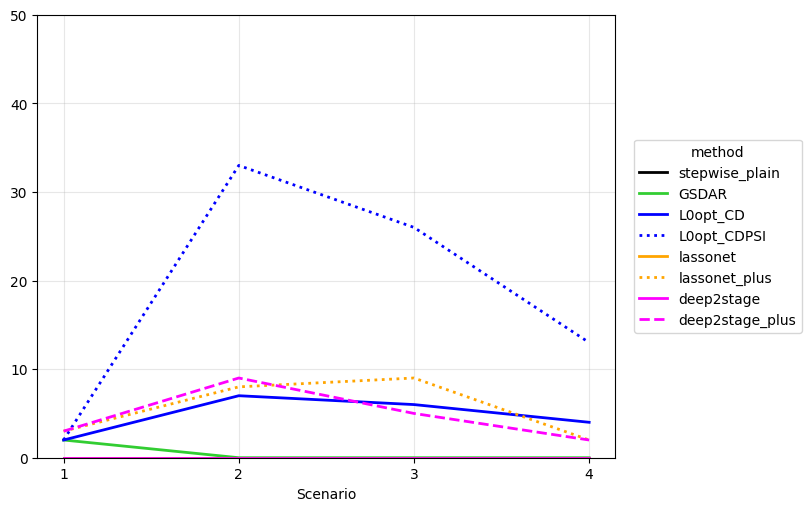

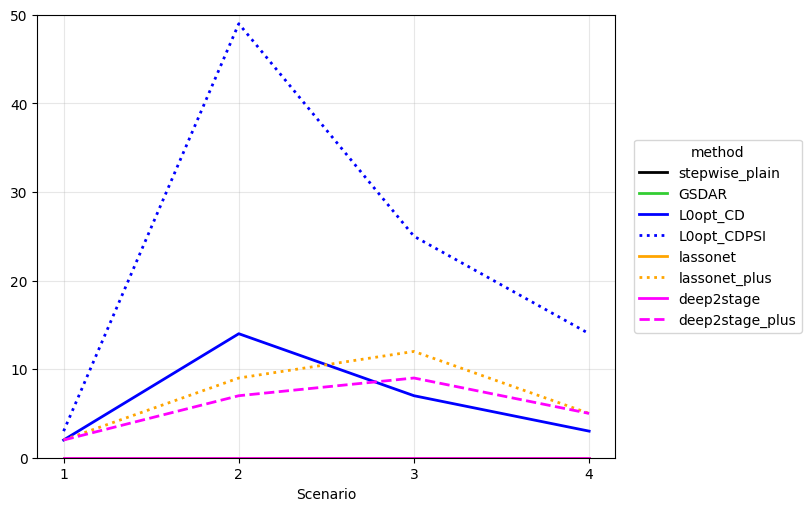

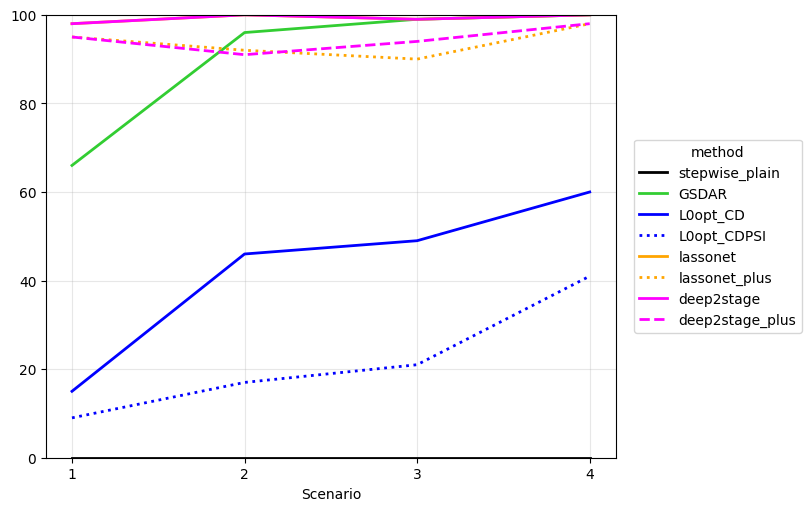

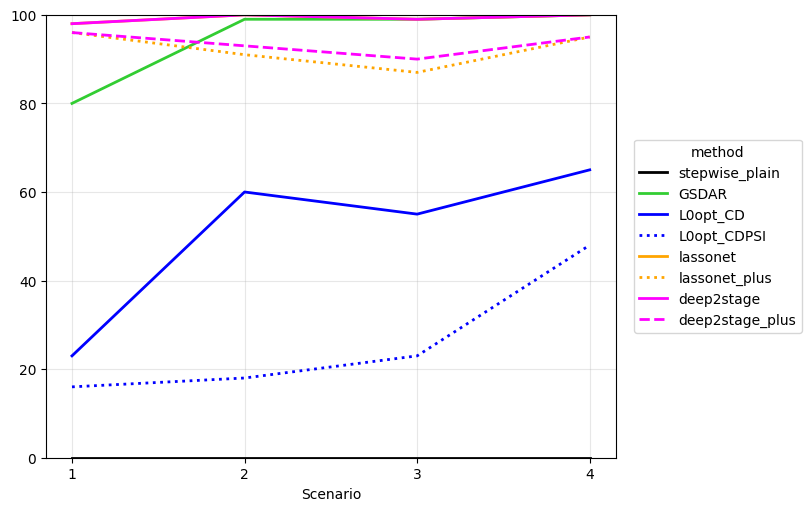

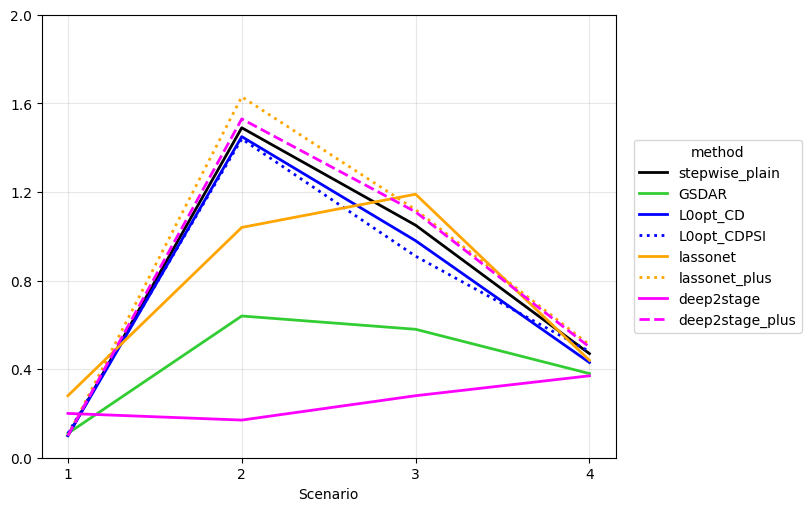

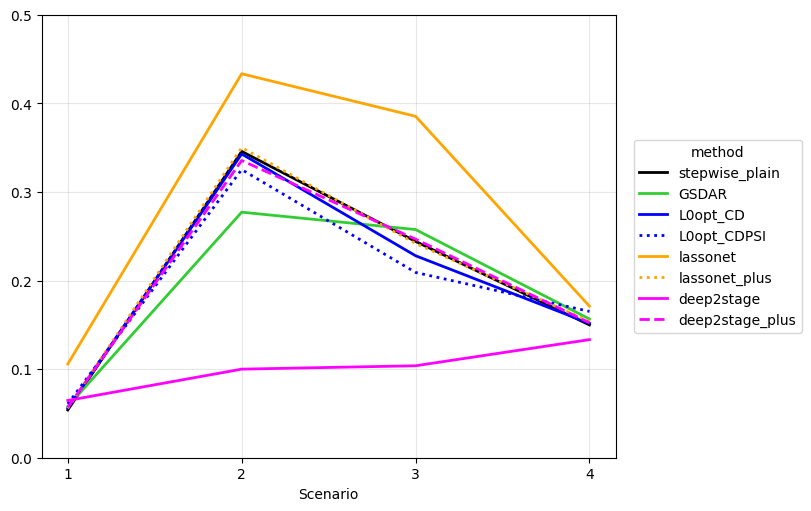

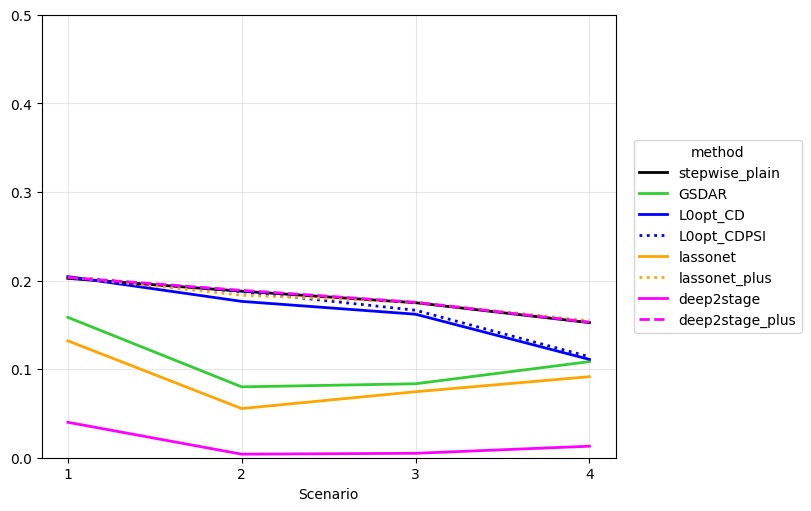

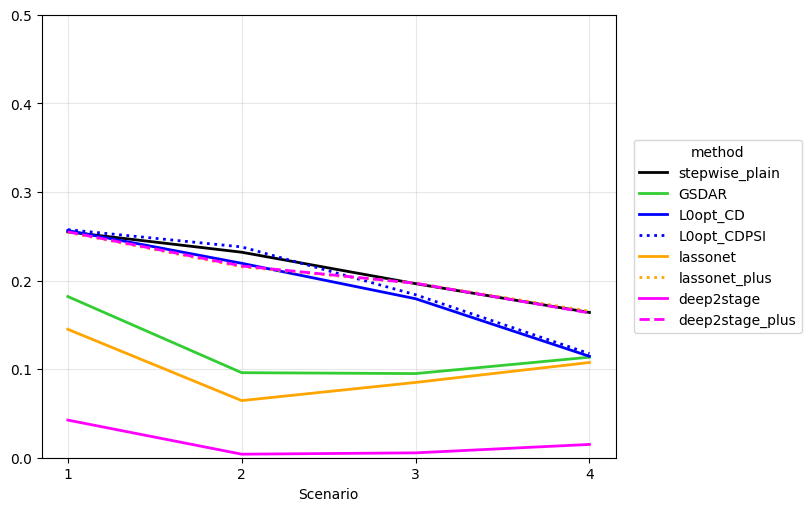

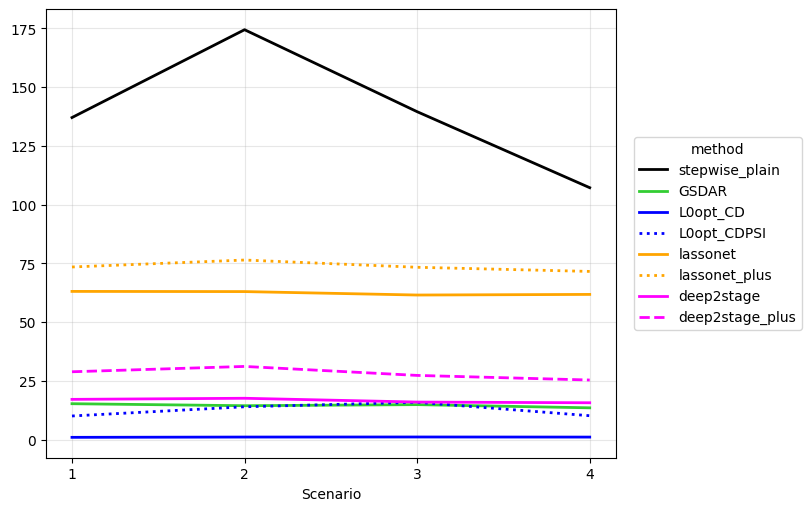

In [57]:
#### Improvements / Worsenings
plot_stepwise_by_scenario(df, metric='mBIC',  kind='improvements', ymax=50)
plot_stepwise_by_scenario(df, metric='mBIC2', kind='improvements', ymax=50)
plot_stepwise_by_scenario(df, metric='mBIC',  kind='worsenings',  ymax=100)
plot_stepwise_by_scenario(df, metric='mBIC2', kind='worsenings',  ymax=100)

# FP / FDR / Power / Runtime
plot_metric_by_scenario(df, which='mBIC',  metric='FP',      ymax=2)
plot_metric_by_scenario(df, which='mBIC2', metric='FDR',     ymax=0.5)
plot_metric_by_scenario(df, which='mBIC',  metric='Power',   ymax=0.5)
plot_metric_by_scenario(df, which='mBIC2', metric='Power',   ymax=0.5)
plot_metric_by_scenario(df, which='mBIC',  metric='Runtime', ymax=None)



## Distribution of mBIC values, mBIC2, runtime

In [64]:
import textwrap

def facet_boxplot_by_scenario(long_df, value_col,
                              title, subtitle=None,
                              ylim=None, whis=1.5, marker_size=12,
                              drop_methods=None, label_map=None, wrap_width=None,
                              y_labelpad=16, left_margin=0.08):
    """
    Facettierte Boxplots je Scenario.
    - zeigt NUR Outlier-Punkte jenseits der Whisker (whis*IQR),
      exakt zentriert über der Box (kein Jitter).
    - label_map: {method: "schöne Beschriftung"}
    - wrap_width: int -> bricht lange Labels in mehrere Zeilen
    - y_labelpad: Abstand Y-Label <-> Achse
    - left_margin: 0..1, extra Platz links
    """
    if long_df.empty:
        print("Keine Daten für", value_col); 
        return

    # ggf. Methoden entfernen
    if drop_methods:
        long_df = long_df[~long_df['method'].isin(drop_methods)].copy()
        if pd.api.types.is_categorical_dtype(long_df['method']):
            long_df['method'] = long_df['method'].cat.remove_unused_categories()

    scen_list = sorted(long_df['scenario'].unique())
    n_panels = len(scen_list)

    # Methoden-Reihenfolge
    full = (method_order if 'method_order' in globals() else list(long_df['method'].unique()))
    methods = [m for m in full if m in long_df['method'].unique()]
    if not methods:
        methods = sorted(long_df['method'].unique())

    # Labels bauen
    def _pretty(m):
        lab = label_map.get(m, m) if label_map else m
        if wrap_width:
            lab = "\n".join(textwrap.wrap(lab, width=wrap_width, break_long_words=False))
        return lab
    labels = [_pretty(m) for m in methods]

    fig, axes = plt.subplots(1, n_panels, figsize=(3.2*n_panels + 2, 5.8), sharey=True)
    if n_panels == 1: axes = [axes]

    for ax, scen in zip(axes, scen_list):
        d = long_df[long_df['scenario'] == scen]
        groups = [d.loc[d['method']==m, value_col].dropna().values for m in methods]

        ax.set_facecolor('#EBEBEB')
        # Boxplot ohne Fliers; Whisker nach whis*IQR
        ax.boxplot(groups, labels=labels, showfliers=False, whis=whis, patch_artist=True,
                   medianprops=dict(color='black', linewidth=1.5),
                   boxprops=dict(facecolor='white', edgecolor='black'),
                   whiskerprops=dict(color='black'),
                   capprops=dict(color='black'))

        # Nur Outlier exakt auf der Box-Mitte plotten
        for xi, vals in enumerate(groups, start=1):
            if vals.size == 0: 
                continue
            q1 = np.percentile(vals, 25); q3 = np.percentile(vals, 75); iqr = q3 - q1
            lower = q1 - whis*iqr; upper = q3 + whis*iqr
            out_low  = vals[vals <  lower]
            out_high = vals[vals >  upper]
            if out_low.size:
                ax.scatter(np.full(out_low.shape, xi, dtype=float), out_low,
                           s=marker_size, c='black', alpha=0.8, linewidths=0)
            if out_high.size:
                ax.scatter(np.full(out_high.shape, xi, dtype=float), out_high,
                           s=marker_size, c='black', alpha=0.8, linewidths=0)

        ax.set_xticklabels(labels, rotation=90, ha='center')
        ax.grid(True, axis='y', alpha=0.35)
        if value_col in ('mBIC','mBIC2'):
            ax.axhline(0, color='black', linestyle='--', linewidth=1)
        if ylim is not None:
            ax.set_ylim(ylim)
        #ax.set_title(f"Scenario {scen}", fontsize=12)
        ax.set_xlabel("")

    ylab = {'mBIC':'mBIC', 'mBIC2':'mBIC2', 'Runtime':'Runtime (s)'}[value_col]
    axes[0].set_ylabel(ylab, labelpad=y_labelpad)

    # Titel oben, zentriert + extra Platz links und oben
    #fig.suptitle(title, fontsize=16, y=0.98)
    #if subtitle:
    #    fig.text(0.5, 0.945, subtitle, ha='center', va='top', fontsize=11)

    # Mehr Platz links (für langes Y-Label) + oben (für Titel)
    top = 0.93 if subtitle else 0.95
    fig.tight_layout(rect=[left_margin, 0, 1, top])
    plt.show()


/tmp/ipykernel_1634847/2450211372.py:24: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(long_df['method']):
/tmp/ipykernel_1634847/2450211372.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels, showfliers=False, whis=whis, patch_artist=True,
/tmp/ipykernel_1634847/2450211372.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels, showfliers=False, whis=whis, patch_artist=True,
/tmp/ipykernel_1634847/2450211372.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; suppo

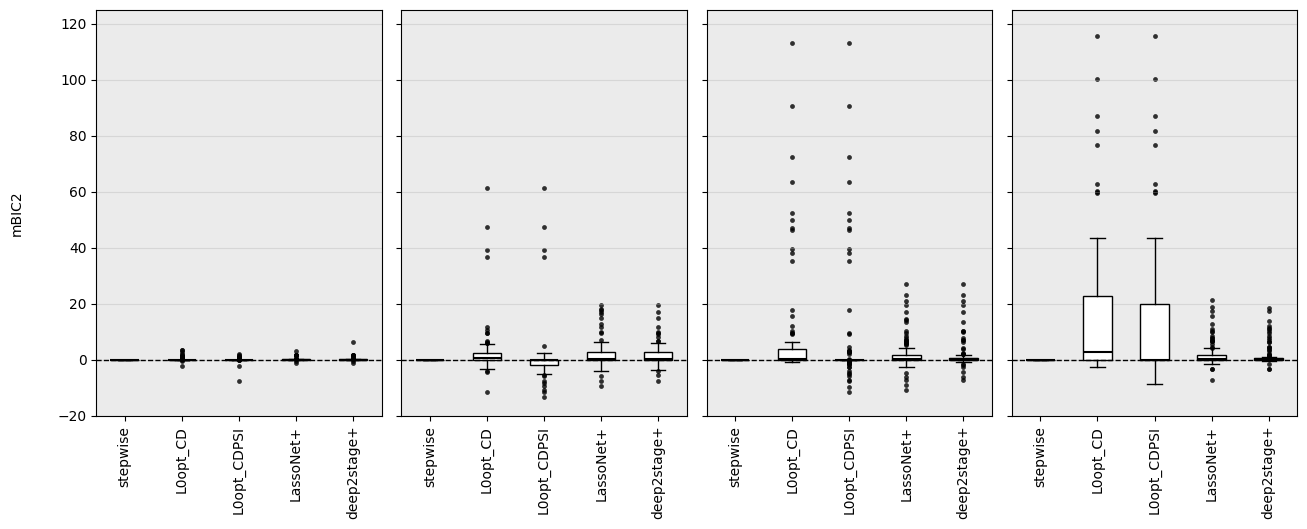

/tmp/ipykernel_1634847/2450211372.py:24: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(long_df['method']):
/tmp/ipykernel_1634847/2450211372.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels, showfliers=False, whis=whis, patch_artist=True,
/tmp/ipykernel_1634847/2450211372.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels, showfliers=False, whis=whis, patch_artist=True,
/tmp/ipykernel_1634847/2450211372.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; suppo

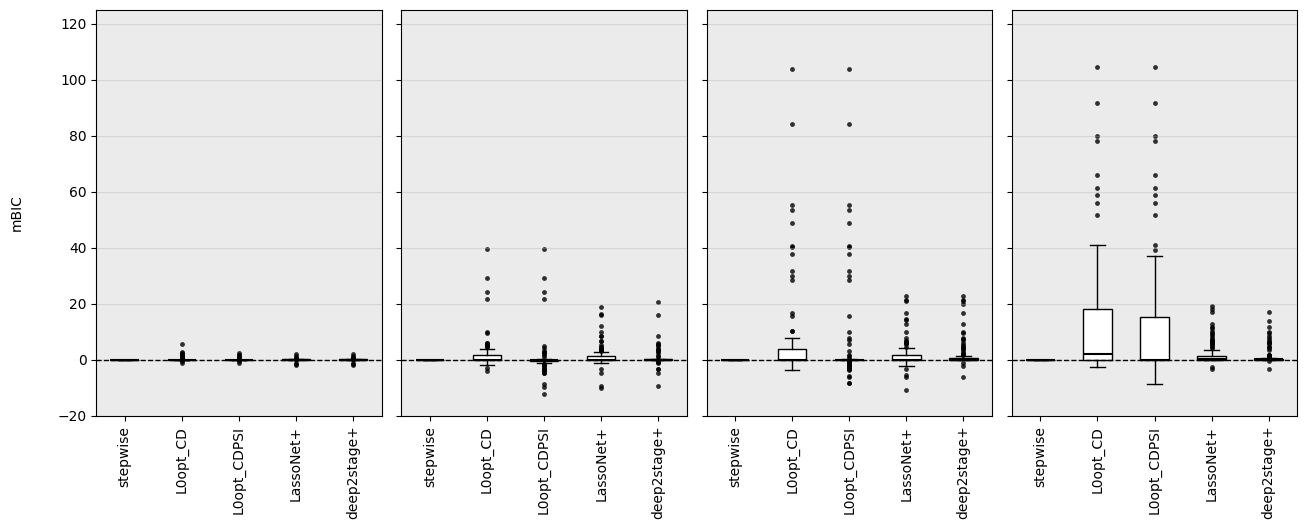

/tmp/ipykernel_1634847/2450211372.py:24: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(long_df['method']):
/tmp/ipykernel_1634847/2450211372.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels, showfliers=False, whis=whis, patch_artist=True,
/tmp/ipykernel_1634847/2450211372.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels, showfliers=False, whis=whis, patch_artist=True,
/tmp/ipykernel_1634847/2450211372.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; suppo

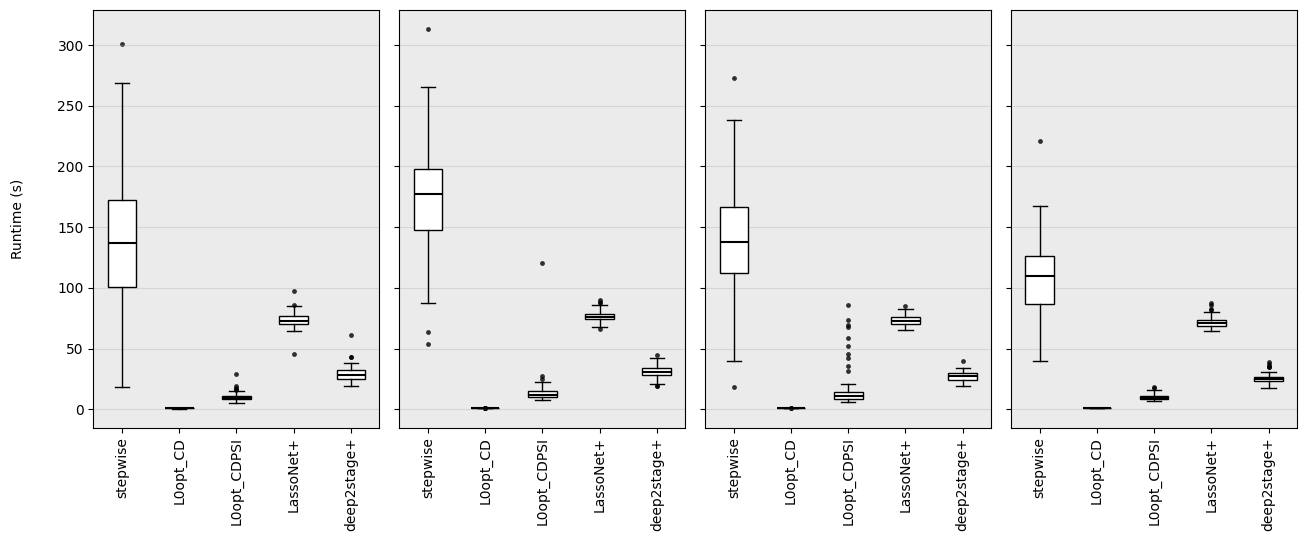

In [65]:
nice_labels = {
    'stepwise_plain': 'stepwise',
    'L0opt_CD': 'L0opt_CD',
    'L0opt_CDPSI': 'L0opt_CDPSI',
    'lassonet_plus': 'LassoNet+',
    'deep2stage_plus': 'deep2stage+',
}

facet_boxplot_by_scenario(
    df_m2_long, 'mBIC2',
    title="mBIC2 values",
    subtitle="stepwise_plain serves as reference",
    drop_methods=['deep2stage', 'lassonet', 'GSDAR'],   # <- hier entfernst du die Methode
    label_map=nice_labels,
    y_labelpad=24, left_margin=0.11,
    ylim=(-20,125),     # z.B. (-20, 300)
    whis=1.5
)

facet_boxplot_by_scenario(
    df_m_long, 'mBIC',
    title="mBIC values",
    subtitle="stepwise_plain serves as reference",
    drop_methods=['deep2stage', 'lassonet', 'GSDAR'],
    label_map=nice_labels,
    y_labelpad=24, left_margin=0.11,
    ylim=(-20,125),     # z.B. (-20, 300)
    whis=1.5
)


facet_boxplot_by_scenario(
    df_rt_long, 'Runtime',
    title="Runtime",
    subtitle=None,
    drop_methods=['deep2stage', 'lassonet', 'GSDAR'],
    label_map=nice_labels,
    y_labelpad=24, left_margin=0.11,
    ylim=None,     # z.B. (0, 30)
    whis=1.5
)

In [70]:
def _sanitize(name: str) -> str:
    # Sauberer Dateiname
    return re.sub(r"[^A-Za-z0-9._-]+", "_", name).strip("_")

def _format_df_for_print(df: pd.DataFrame) -> pd.DataFrame:
    # nutzt dein fmt_num (falls vorhanden), sonst Fallback
    def _fmt_safe(x):
        try:
            return fmt_num(x)
        except Exception:
            if pd.isna(x): return ""
            try:
                v = float(x)
                if float(v).is_integer(): return str(int(v))
                s = f"{v:.2f}"
                return s.rstrip("0").rstrip(".")
            except Exception:
                return str(x)
    out = df.copy()
    for c in out.columns:
        out[c] = out[c].map(_fmt_safe)
    return out

def save_table_png(df: pd.DataFrame, path: Path, title: str = None, dpi: int = 220,
                   header_bg="#f2f2f2", edgecolor="#bdbdbd",
                   fontsize: int = 9, max_col_chars: int = 24) -> None:
    # Ordner sicher anlegen
    path.parent.mkdir(parents=True, exist_ok=True)

    dfp = _format_df_for_print(df)
    col_labels = list(dfp.columns)
    data = dfp.values

    # Spaltenbreiten heuristisch nach Textlänge
    def _col_len(j):
        hl = len(str(col_labels[j]))
        cl = max([len(str(v)) for v in dfp.iloc[:, j]] + [hl])
        return min(cl, max_col_chars)
    w_chars = np.array([_col_len(j) for j in range(len(col_labels))], dtype=float)
    col_widths = (w_chars / w_chars.sum()) if w_chars.sum() > 0 else None

    n_rows = len(dfp)
    cell_h, header_h = 0.35, 0.5
    fig_h = max(2.8, header_h + n_rows * cell_h + 0.6)
    fig_w = max(6.0, 0.6 + 0.14 * w_chars.sum())

    fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=dpi)
    ax.axis("off")
    table = ax.table(cellText=data, colLabels=col_labels, colWidths=col_widths,
                     cellLoc="center", loc="upper center")
    table.auto_set_font_size(False)
    table.set_fontsize(fontsize)
    for (r, c), cell in table.get_celld().items():
        cell.set_edgecolor(edgecolor)
        if r == 0:
            cell.set_facecolor(header_bg)
            cell.get_text().set_weight("bold")
    if title:
        fig.suptitle(title, y=1.02, fontsize=12)
    fig.tight_layout()
    fig.savefig(str(path), bbox_inches="tight")
    plt.close(fig)

def export_tables_png(tables, folder="Figures4", prefix="Sim4_", suffix=""):
    base = Path(folder)
    saved = []
    for name, tbl in tables:
        if tbl is None or (hasattr(tbl, "empty") and tbl.empty):
            continue
        fname = _sanitize(f"{prefix}{name}{suffix}") + ".png"
        out_path = base / fname
        save_table_png(tbl, out_path, title=name)  # nutzt deine bestehende save_table_png
        saved.append(str(out_path))
    return saved

In [71]:
png_paths = export_tables_png(tables, folder="Figures4", prefix="Sim4_")
print("Gespeichert:", *png_paths, sep="\n- ")

Gespeichert:
- Figures4/Sim4_Number_of_Improvements_mBIC.png
- Figures4/Sim4_Number_of_Improvements_mBIC2.png
- Figures4/Sim4_Number_of_Worsenings_mBIC.png
- Figures4/Sim4_Number_of_Worsenings_mBIC2.png
- Figures4/Sim4_Type_1_Error_Rate_Average_False_Positives_using_mBIC.png
- Figures4/Sim4_Type_1_Error_Rate_FDR_using_mBIC2.png
- Figures4/Sim4_Power_for_mBIC.png
- Figures4/Sim4_Power_for_mBIC2.png
- Figures4/Sim4_Runtime_mBIC_and_mBIC2_combined.png
- Figures4/Sim4_Mean_difference_for_mBIC_stepwise_as_reference.png
- Figures4/Sim4_SEM_of_difference_for_mBIC.png
- Figures4/Sim4_Mean_difference_for_mBIC2_stepwise_as_reference.png
- Figures4/Sim4_SEM_of_difference_for_mBIC2.png
